# Introduction

We are going to numerically find the ground state of 1-dimensional Gross-Pitaevskii equation:

$$-\frac{\hbar^2}{2m}\psi''(x) + V_{trap}(x)\psi(x) + g|\psi(x)|^2\psi(x) = \mu\psi(x)$$

This will be achieved using imaginary time propagation and split-step-fft method.

In the first part of notebook we consider split-step-fft method for evolution of wave-function of general Schrödinger equation. 

In the second part we implement imaginary time propagation for the same equation to obtain the ground state.

In the third part we turn back to GPE and provide calculation for this case.

# Split-Step-FFT Method

Evolution of the wave function can be obtained by applying the operator of evolution $\hat U = e^{-\frac{i}{\hbar} \hat H t}$

Decompose the time independent Hamiltonian $\hat H = \hat T + \hat V$ into kinetic energy part $\hat T$ and the potential energy part $\hat V$. The calculation is realized on a grid.

Define operators $\tilde T = -\frac{i}{\hbar}\hat T \Delta t$ and $\tilde V = -\frac{i}{\hbar}\hat V \Delta t$. Generally they do not commute. For non-commuting operators one should use Baker-Campbell-Hausdorff formula for exponents, thus obtain: 

$$\hat U = e^{\tilde T / 2 + \tilde V + \tilde T / 2} \propto e^{\tilde T / 2} \cdot e^{\tilde V} \cdot e^{\tilde T / 2} \cdot e^{\mathcal O(\Delta t^3)} $$

Terms with $e^{[\ldots, \ldots]}$ just cancell, so the hole error is order of 3 and thus can be made negligible for sufficiently short time steps $\Delta t$.

Thus we approximate $\hat U = e^{\tilde T / 2} \cdot e^{\tilde V} \cdot e^{\tilde T / 2}$

An efficient calculation of propogator is possible when $\hat T$ and $\hat V$ are diagonal in momentum space and real space correspondently. That leads to the following algrotihm for computation of one time step:

1. Fourier transformation of $\psi(x)$.
2. Multiplication with diagonal matrix elements $e^{-\frac{i}{\hbar}\frac{\hbar^2k^2}{2m}\frac{\Delta t}{2}}$.
3. Inverse Fourier transformation.
4. Multiplication with diagonal matrix elements $e^{-\frac{i}{\hbar}V(x)\Delta t}$.
5. Fourier transformation.
6. Multiplication with diagonal matrix elements $e^{-\frac{i}{\hbar}\frac{\hbar^2k^2}{2m}\frac{\Delta t}{2}}$.
7. Inverse Fourier transformation.

This procedure is implemented in the following function.

In [2]:
import numpy as np
import math
from scipy.fftpack import fft, ifft
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

In [2]:
def evolve(psi_x0_, V_x_, T_k_, dt_, hbar=1.0):
    """

    :param psi_x0_: array_like, complex; initial wave function
    :param V_x_: array_like, float; potential at each x
    :param T_k_: array_like, float; kinetic energy at each k
    :param dt_: float; time of one evolution step
    :param hbar: float; Planck's constant (default=1.0)
    :return: final wave function after one evolution step
    """

    psi = psi_x0_
    # change to momentum space
    psi = fft(psi)
    # half-evolution in momentum space
    psi *= np.exp(-0.5j * T_k_ * dt_ / hbar)
    # back to real space
    psi = ifft(psi)
    # evolution in real space
    psi *= np.exp(-1.j * V_x_ * dt_ / hbar)
    # change to momentum space
    psi = fft(psi)
    # half-evolution in momentum space
    psi *= np.exp(-0.5j * T_k_ * dt_ / hbar)
    # back to real space
    psi = ifft(psi)

    return psi

Let us simulate the behaviour of free gaussian wave-packet. 

In [3]:
def gauss_x(x, a, x0, k0):
    """
    a gaussian wave packet of width a, centered at x0, with momentum k0
    """
    return ((a * np.sqrt(np.pi)) ** (-0.5)
            * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))

We create a x-grid in the real space and corresponding k-grid in the momentum space and set up initial functions.

In [60]:
"""
Parameters
__________
N:  size of grid
dx: gap
x:  grid array
k:  momentum space grid
dk: momentum space gap
psi_x0: initial wave function
V_x: potential
hbar: Planck's constant
m: mass of particle
dt: time-step
"""

N = 2 ** 11
dx = 0.1
x = np.arange(N)
k = np.append(x[:N//2], -x[N//2:0:-1])
x = dx * (x - 0.5 * N)
dk = np.pi / np.max(x)
k = k * dk

hbar = 1.0
m = 1.0

V_x = np.zeros(np.size(x))

T_k = 0.5 * hbar ** 2 * k * k / m

psi_x = gauss_x(x, 5, -50, 5)

dt = 0.01

Create an animation.

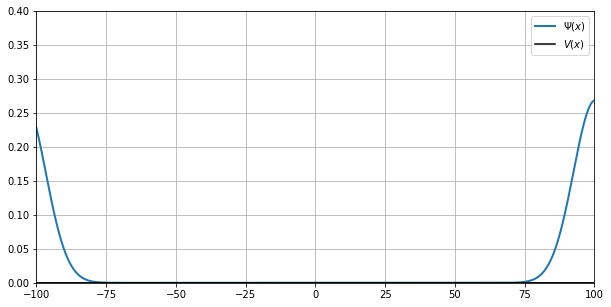

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(-100, 100), ylim=(0, 0.4))

line, = ax.plot([], [], label=r'$\Psi(x)$', lw=2)
V_x_line, = ax.plot([], [], c='k', label=r'$V(x)$')
V_x_line.set_data(x, V_x)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    V_x_line.set_data([], [])
    return line, V_x_line,


# animation function. This is called sequentially
def animate(i):
    global psi_x
    for step in range(10):
        psi_x = evolve(psi_x, V_x, T_k, dt)
    V_x_line.set_data(x, V_x)
    line.set_data(x, np.abs(psi_x))
    return line, V_x_line,


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=20, blit=True)
plt.legend()
plt.grid()

HTML(anim.to_html5_video())

Here we can see a slight spreading of the wave packet. 

# Imaginary Time Propagation

Consider a general wave function $\psi_0 = \sum_k c_k \phi_k$, where $\phi_k$ is an eigenvalue for a hamiltonian $\hat H$: $\hat H \phi_k = \epsilon_k \phi_k$. We are to show that by Wick's rotation $t \rightarrow -i\tau$ for sufficiently long time $\tau$ the wave function approachs the ground state:

$$e^{-\frac{i}{\hbar}\hat H t}\psi_0 \rightarrow c_0 \phi_0,\ t = -i\tau,\ \tau \rightarrow \infty$$

**Proof**

Put in evolution operator interchange $t \rightarrow -i\tau$

$$e^{-\frac{i}{\hbar}\hat H t}\psi_0 = e^{-\frac{\hat H}{\hbar}\tau}\psi_0 = e^{-\frac{\hat H}{\hbar}\tau}\sum_k c_k \phi_k = \sum_k c_k e^{-\frac{\hat H}{\hbar}\tau} \phi_k = \sum_k c_k e^{-\frac{\epsilon_k}{\hbar}\tau} \phi_k = \ldots$$

For energies we have $$\epsilon_0 < \epsilon_1 < \ldots < \epsilon_k < \ldots$$

Thus we can take out of sum $\epsilon_0$ term and neglect other terms for sufficiently big values of $\tau$.

$$\ldots = c_0e^{-\frac{\epsilon_0}{\hbar}\tau}\left(1\cdot\phi_0 + \sum_{k = 1}^\infty e^{-\frac{\epsilon_k - \epsilon_0}{\hbar}\tau}\phi_k\right) \rightarrow c_0 e^{-\frac{\epsilon_0}{\hbar}\tau}\phi_0 = \ldots$$

Without loss of generality we choose $\epsilon_0 = 0$, so finally we obtain $$\ldots = c_0 \phi_0$$

Thus, we obtain an algorithmical procedure to calculate the ground state. Put Wick's rotation into our evolutional function and by the end of each time step let us normalize wave function. The statement yields that finally we approach the ground state of Hamiltonian.

## Infinite Well Potential

Consider infinite well potential 

$$V(x) = \begin{cases} 0, & \mbox{if } x \in (-a/2, a/2) \\ \infty, & \mbox{else}\end{cases}$$ 

and let us simulate imaginary time propagation to obtain the ground state 

$$\Psi_{gs} = \sqrt{\frac{2}{a}}\sin{\left(\frac{\pi}{a}\left(x + \frac{a}{2}\right)\right)}$$



In [12]:
# set new parameters

V_x = np.zeros(np.size(x))
V_x[x < -50] = 1E8
V_x[x > 50] = 1E8

psi_x = gauss_x(x, 10, 0, 0)

dt = 0.01

In [47]:
def wf_norm(wave_fn):
    """
    Returns the norm of a wave function.

    Parameters
    ----------
    wave_fn : array
        Length-N array of the wavefunction in the position representation
    """
    return np.sqrt((np.abs(wave_fn) ** 2).sum() * dx)

In [14]:
# set up ground state function

gr_st = np.sin(np.pi * (x + 50) / 100) * math.sqrt(2 / 100)
gr_st[x < -50] = 0
gr_st[x > 50] = 0

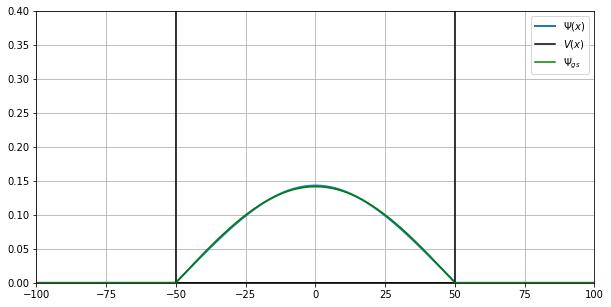

In [16]:
# animation

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(-100, 100), ylim=(0, 0.4))
line, = ax.plot([], [], label=r'$\Psi(x)$', lw=2)
V_x_line, = ax.plot([], [], c='k', label=r'$V(x)$')
ground_state, = ax.plot([], [], c='g', label=r'$\Psi_{gs}$')
V_x_line.set_data(x, V_x)
ground_state.set_data(x, gr_st)


# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    V_x_line.set_data([], [])
    ground_state.set_data([], [])
    return line, V_x_line, ground_state,


# animation function.  This is called sequentially
def animate(i):
    global psi_x
    for num in range(200):
        psi_x = evolve(psi_x, V_x, T_k, -1.j * dt)
        norm = wf_norm(psi_x)
        psi_x = psi_x / norm
    V_x_line.set_data(x, V_x)
    line.set_data(x, np.abs(psi_x))
    ground_state.set_data(x, gr_st)
    return line, V_x_line, ground_state,


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=20, blit=True)

plt.legend()
plt.grid()

HTML(anim.to_html5_video())

# 1D Gross-Pitaevskii Equation for Harmonic Trap

Finally consider the Gross-Pitaevskii with harmonic potential 

$$\left(-\frac{1}{2}\frac{d^2}{d x^2} + \frac{\omega^2}{2}x^2 + g|\psi|^2\right)\psi = \mu \psi$$

Hamiltonian for this equation includes also the non-linear term $g|\psi|^2$, thus we should add multiplication by $\exp{(-ig|\psi|^2\Delta t/\hbar)}$ to our algorithm. So, slightly change evolutional function.

In [10]:
def evolve_GPE(psi_x0_, V_x_, T_k_, dt_, g_, hbar=1.0):
    """

    :param psi_x0_: array_like, complex; initial wave function
    :param V_x_: array_like, float; potential at each x
    :param T_k_: array_like, float; kinetic energy at each k
    :param dt_: float; time of one evolution step
    :param g_: float; strength of interaction
    :param hbar: float; Planck's constant (default=1.0)
    :return: final wave function after one evolution step
    """

    psi = psi_x0_
    # change to momentum space
    psi = fft(psi)
    # half-evolution in momentum space
    psi *= np.exp(-0.5j * T_k_ * dt_ / hbar)
    # back to real space
    psi = ifft(psi)
    # evolution in real space
    psi *= np.exp(-1.j * V_x_ * dt_ / hbar)
    psi_sq = np.multiply(np.conj(psi), psi)
    psi *= np.exp(-1.j * g_ * dt_ * psi_sq / hbar)
    # change to momentum space
    psi = fft(psi)
    # half-evolution in momentum space
    psi *= np.exp(-0.5j * T_k_ * dt_ / hbar)
    # back to real space
    psi = ifft(psi)

    return psi

Now we are going to combine both methods discussed above and calculate ground state of Gross-Pitaevskii equation.

In [49]:
# set potential, initial wave function, parameters

g = 6
omega_sq = 0.001

V_trap = 0.5 * omega_sq * np.square(x)

psi_x = gauss_x(x, 5, 0, 0)

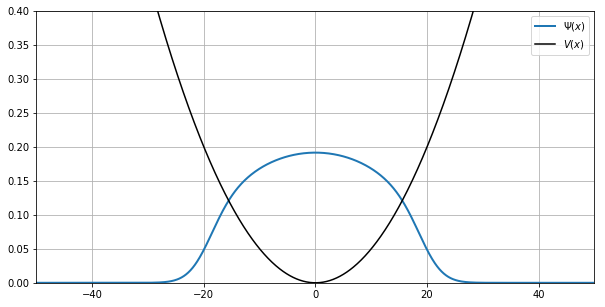

In [50]:
# animation

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(xlim=(-50, 50), ylim=(0, 0.4))
line, = ax.plot([], [], label=r'$\Psi(x)$', lw=2)
V_x_line, = ax.plot([], [], c='k', label=r'$V(x)$')
V_x_line.set_data(x, V_trap)


def init():
    line.set_data([], [])
    V_x_line.set_data([], [])
    return line, V_x_line,


def animate(i):
    global psi_x
    for num in range(15):
        psi_x = evolve_GPE(psi_x, V_trap, T_k, -1.j * dt, g)
        norm = wf_norm(psi_x)
        psi_x = psi_x / norm
    V_x_line.set_data(x, V_trap)
    line.set_data(x, np.abs(psi_x))
    return line, V_x_line,


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

plt.legend()
plt.grid()

HTML(anim.to_html5_video())

In [6]:
def hamiltonian(x, wave_fn_, m_, g_, omega_sq_, hbar=1.):
    trap_term = 0.5 * omega_sq_ * np.multiply(np.square(x), wave_fn_)
    non_linear_term = g_ * np.multiply(np.square(np.abs(wave_fn_)), wave_fn_)
    kinetic_term = - hbar * hbar * np.multiply(np.gradient(np.gradient(wave_fn_, x), x), wave_fn_)
    return kinetic_term + trap_term + non_linear_term

In [7]:
def av_energy(x, wave_fn_, m_, g_, omega_sq_, hbar=1.):
    func = np.multiply(np.conj(wave_fn_), hamiltonian(x, wave_fn_, m_, g_, omega_sq_, hbar))
    return np.trapz(np.abs(func), x)

In [53]:
print(av_energy(x, psi_x, m, g, omega_sq))

0.21899249085499378


## Rubidium Atoms in Harmonic Trap

Consider a problem with specific parameters. Put rubidium atoms $\left(^{87}Rb\right)$ inside the harmonic trap. Write down the GPE for this system:

$$\left(-\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + \frac{m \omega^2}{2}x^2 + \frac{4\pi\hbar^2 a}{m}n_0\left|\psi\right|^2\right)\psi(x) = \mu \psi(x)$$

* $m = 87 \times m_p$, mass of $^{87}Rb$ atom

* $\omega = 2\pi \times 100$ Hz

* $a = 103a_0$ (whera $a_0$ stands for Bohr radius)

* $n_0 = 10^{14} cm^{-2}$

We make the change of variables to get dimensionless $\xi = \frac{x}{l}$, $\phi = \psi l$, where $l$ is given by 

$$l = \sqrt{\frac{\hbar}{2m\omega}}$$

and have dimension of length. Thus we obtain:

$$\left(-\hbar \omega \frac{d^2}{d \xi^2} + \frac{\hbar \omega}{4}\xi^2 + 4\cdot10^{-4}\cdot\alpha\cdot n_0 \cdot a^2 \sqrt{\frac{m_ec^2}{\hbar \omega}}\cdot\hbar \omega \cdot \left|\phi\right|^2\right)\phi(\xi) = \mu \phi(\xi)$$

where $\alpha$ is the fine-structure constant. Dividing by $\hbar \omega$, using dimensionless reduced chemical potential $\eta = \mu / \hbar \omega$ get:

$$\left(- \frac{1}{2}\frac{d^2}{d \xi^2} + \frac{1}{8}\xi^2 + 10 \cdot N \cdot \left|\phi\right|^2\right)\phi(\xi) = \eta \phi(\xi)$$

where $N$ is the parameter of strength (for this case $N = 100$).

Here we can see how wave function varies depending on the strength.

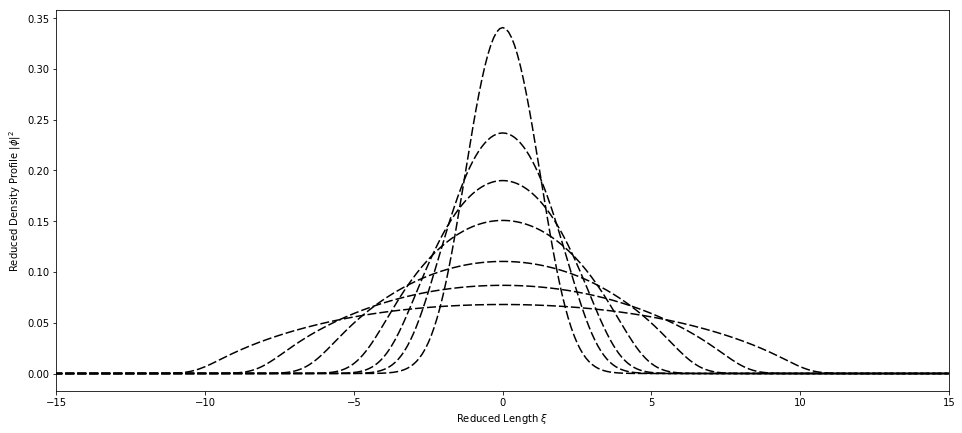

In [87]:
sample = [1, 5, 10, 20, 50, 100, 200]
energies = [0, 0, 0, 0, 0, 0, 0]
omega_sq = 0.25
V_trap = 0.5 * omega_sq * np.square(x)
dt = 0.01
i = 0

fig = plt.figure(figsize=(16, 7))
ax = plt.axes(xlim=(-15, 15))


for num in sample:
    g = num
    psi_x = gauss_x(x, 5, 0, 0)
    for step in range(10000):
        psi_x = evolve_GPE(psi_x, V_trap, T_k, -1.j * dt, g)
        norm = wf_norm(psi_x)
        psi_x = psi_x / norm
    energies[i] = av_energy(x, psi_x, m, g, omega_sq)
    i += 1
    line, = ax.plot(x, np.square(np.abs(psi_x)), c='k')
    line.set_dashes([6, 2])


plt.xlabel(r'Reduced Length $\xi$')
plt.ylabel(r'Reduced Density Profile $\left|\phi\right|^2$')

plt.show()

In [84]:
for en in energies:
    print(en)

0.5278235469668889
1.2446487985680674
1.9348023426584637
3.047253980659648
5.592769823245197
8.865370902162262
14.05391647775975
